In [1]:
import quimb.tensor as qtn
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import itertools
import denseQubits as dq
import exact_jwt
import stabilizers as stab
import qubitNetworks as beeky
from itertools import product
import functools
from quimb.tensor.tensor_core import tags_to_oset as tto

In [58]:
print(norm^all)
norm.contract_boundary_from_bottom(yrange=(0,4), xrange=(1,4), layer_tags=('BRA','KET'))^all
# norm.graph_layers()


(0.805528535975503+0j)


0.8055285359755008

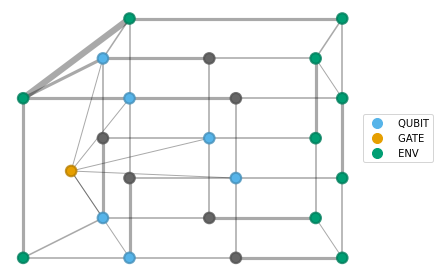

In [3]:
reload(beeky)
SimHam = beeky.SpinlessSimHam(3,3)
where_gate = (4,7,10)
# which_mpo = mpoham.get_term_at(*where_gate)

which_gate = SimHam.get_term_at(*where_gate)

psi = beeky.QubitEncodeVector.rand(3,3)
psi.setup_bmps_contraction_()
norm, bra, ket = psi.make_norm(return_all=True)

plaq_info = ((2,2), (3,2))
plaq_envs = norm.compute_plaquette_environments(x_bsz=3, y_bsz=2, first_contract='rows', layer_tags=('BRA','KET'))

plaq_tags = psi.plaquette_at(xy=plaq_info[0], bsz=plaq_info[1], get='tags')
env = plaq_envs[plaq_info]
env.add_tag('ENV')

ket_local = ket.select_any(plaq_tags).view_like_(psi)
bra_and_env = bra.select_any(plaq_tags) | env

# composite = (ket_local.apply_mpo(mpo=which_mpo, where=where_gate, contract=False) | bra_and_env).view_like_(psi)
composite = (ket_local.apply_gate(which_gate, where_gate, contract=False) | bra_and_env).view_like(psi)

composite.graph(layer_tags=('BRA','KET'),color=['QUBIT', 'GATE', 'ENV'])



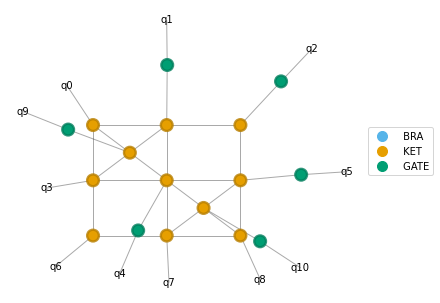

In [64]:
reload(beeky)
qlat = dq.QubitLattice(3,3)
hstab = beeky.HamStab(qlat)
stab_term = list(hstab.gen_ham_stabilizer_lists())[0]

psish = beeky.QubitEncodeVector.rand(Lx=3,Ly=3, bond_dim=2)
for k in range(6):
    qubit = stab_term[0][k]
    gate = stab_term[1][k]
    psish.apply_gate_(G=gate, where=qubit, contract=False)
psish.add_tag('KET')
psish.graph(color=['BRA','KET','GATE'])
# psish.setup_bmps_contraction_()
# norm = psish.make_norm()
# norm.graph_layers(color=['BRA','KET','GATE'])
# norm.graph()

In [4]:
reload(beeky)
reload(dq)
# from collections import defaultdict

LX, LY = 3, 3
T_PARAM, V_PARAM, MU_PARAM = (1, 0.2, 0.5)
D_PEPS = 2

qlat = dq.SpinlessHub(Lx=LX, Ly=LY)
mpoHam = beeky.MPOSpinlessHam(qlat, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
HubHam = beeky.SpinlessSimHam(Lx=LX, Ly=LY, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)

qubit_terms = dict(HubHam.gen_ham_terms())

horizontal_terms = dict(HubHam.gen_horizontal_ham_terms())

vertical_terms = dict(HubHam.gen_vertical_ham_terms())

qvec = beeky.QubitEncodeVector.rand(LX, LY, bond_dim=D_PEPS)


energies = dict()
exact_energies = dict()

E_exact = qvec.compute_ham_expec(HubHam) 
print(E_exact)
exact_energies[D_PEPS] = E_exact
print(qvec.compute_mpo_ham_expec(mpoHam))


(-1.3365324872522142+5.3582176966458064e-17j)
(-1.3365324872522142-2.4310432142189306e-17j)


In [43]:
qtest = qvec.copy()
qtest.setup_bmps_contraction_()

for chi in range(3, 15):
    
    # if (chi, D_PEPS) not in energies:

    he = qtest.compute_local_expectation(horizontal_terms, normalized=True, max_bond=chi)

    ve = qtest.compute_local_expectation(vertical_terms, normalized=True, max_bond=chi)

    energies[chi, D_PEPS] = he + ve



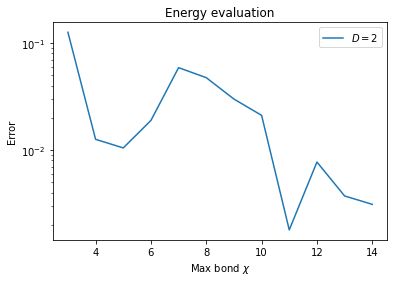

In [44]:
from collections import defaultdict
diffs = defaultdict(list)
chis = defaultdict(list)

for k, v in energies.items():
    D = k[1]
    diffs[D].append(abs(v - exact_energies[D]))
    chis[D].append(k[0])

for d in [2]:
    plt.semilogy(chis[d], diffs[d], label=f'$D={d}$')
plt.xlabel(r'Max bond $\chi$')
plt.ylabel(r'Error')
plt.title(r'Energy evaluation')
plt.legend()


In [13]:
import optimize as myopt
from quimb.tensor.optimize import TNOptimizer
reload(beeky)
reload(myopt)
LX, LY = 3, 3
HubSimHam = beeky.SpinlessSimHam(Lx=LX, Ly=LY)

horizontal_terms = dict(HubSimHam.gen_horizontal_ham_terms())
vertical_terms = dict(HubSimHam.gen_vertical_ham_terms())

compute_expec_opts = dict(cutoff=2e-3, max_bond=9, contract_optimize='random-greedy')

normalize_state = myopt.normalize_state
state_energy = myopt.state_energy

psi0 = beeky.QubitEncodeVector.rand(Lx=LX, Ly=LY, bond_dim=3)
psi0.setup_bmps_contraction_()

optmzr = TNOptimizer(
        psi0, # initial state guess
        loss_fn=state_energy,
        norm_fn=normalize_state,
        constant_tags=('AUX',), # ignore identities
        loss_constants={'hterms': horizontal_terms,
                        'vterms': vertical_terms},
        loss_kwargs={'opts': compute_expec_opts},
        autodiff_backend='tensorflow',
    )


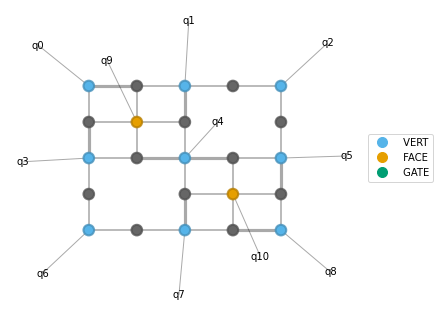

In [14]:
psi0.graph()

In [10]:
tn_opt = optmzr.optimize(1)

0%|          | 0/1 [00:00<?, ?it/s]


InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a complex128 tensor but is a double tensor [Op:Mul] name: mul/